## 1 Виртуальный датчик

In [99]:
import pandas as pd 

df_data = pd.read_csv('data_lec.csv',  parse_dates=['timestamp'])
df_target = pd.read_csv('target_lec.csv',  parse_dates=['timestamp'])

# Приведение данных к временной шкале с фиксированным шагом
# Устанавливаем индекс для временных меток
df_data.set_index('timestamp', inplace=True)
df_target.set_index('timestamp', inplace=True)

# Интерполяция target на частоту data (1 минута)
df_target_interpolated = df_target.resample('1T').interpolate(method='linear')

start_date = df_target_interpolated.index.min()
end_date = df_target_interpolated.index.max()

# Выделим нужный участок из df_data
df_data_selected = df_data.loc[start_date:end_date]

# Объединим df_data_selected с df_target_interpolated, добавив target в отдельную колонку
df_combined = df_data_selected.join(df_target_interpolated, rsuffix='_target')
df_combined = df_combined.fillna(method='bfill').dropna()

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\3359892476.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_target_interpolated = df_target.resample('1T').interpolate(method='linear')
C:\Users\minak\AppData\Local\Temp\ipykernel_50108\3359892476.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined = df_combined.fillna(method='bfill').dropna()


In [100]:
from sklearn.preprocessing import MinMaxScaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

for i in range(1, 16):
    df_combined[f'target_lag_{i}'] = df_combined['target'].shift(i)

# Применяем MinMaxScaler к df_combined, чтобы нормализовать все числовые столбцы
df_combined = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)
       
df_combined = df_combined.fillna(method='bfill').dropna()
# Вычисляем длины каждого набора
total_length = len(df_combined)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.9)

# Разделение данных
train_data = df_combined.iloc[:train_end]
val_data = df_combined.iloc[train_end:val_end]
test_data = df_combined.iloc[val_end:]

# Проверим размеры каждого набора для подтверждения
train_data_size = len(train_data)
val_data_size = len(val_data)
test_data_size = len(test_data)

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\1374085553.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined = df_combined.fillna(method='bfill').dropna()


In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Подготовка признаков и целевой переменной
X_train = train_data.drop(columns=['target_target'])
y_train = train_data['target_target']

# Обучение модели линейной регрессии
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Оценка модели на тренировочном наборе
y_pred_train = model_lr.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

print(f'RMSE на тренировочных данных: {rmse_train} ')

RMSE на тренировочных данных: 0.042329773730124594 


Вывидим на график результат предсказаний на валидационной выборке

<Axes: xlabel='timestamp'>

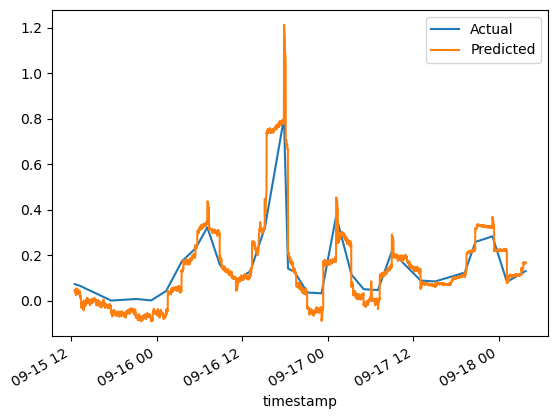

In [102]:
# Подготовка признаков и целевой переменной для валидации
X_val = val_data.drop(columns=['target_target'])
y_val = val_data['target_target']

# Прогнозирование на валидационном наборе
y_pred_val = model_lr.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

val_results.plot()

In [103]:
# Создаём копию y_val с сохранением индекса
sensor_val = y_val.copy()

# Заменяем значения на y_pred_val, сохраняя индекс
sensor_val[:] = y_pred_val

Денармализуем данные

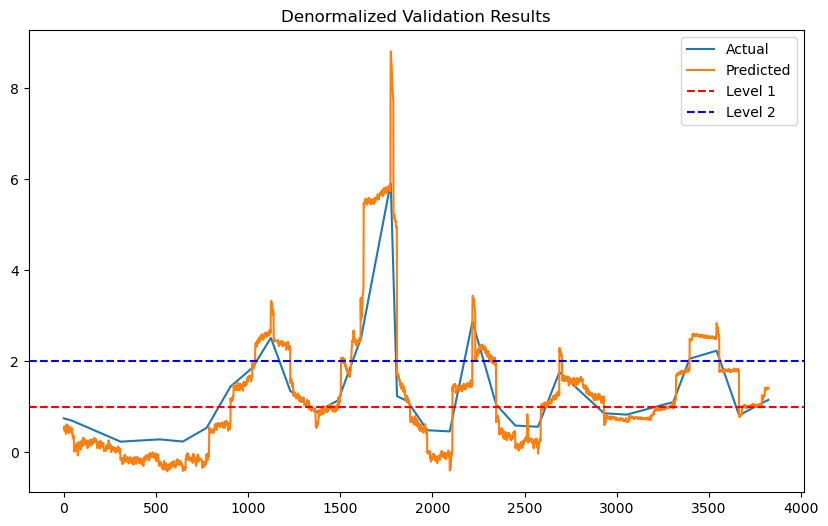

In [104]:
# Денормализация 'Actual'
actual_denormalized = scaler.inverse_transform(val_data)[:, val_data.columns.get_loc('target_target')]

# Денормализация 'Predicted'
predicted_denormalized = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_val), X_val.shape[1])), y_pred_val.reshape(-1, 1)])
)[:, -1]

# Создание DataFrame
val_results_denormalized = pd.DataFrame({
    'Actual': actual_denormalized,
    'Predicted': predicted_denormalized
})

import matplotlib.pyplot as plt

# Построение графика
ax = val_results_denormalized.plot(figsize=(10, 6), title="Denormalized Validation Results")

# Добавление линий на уровне 1 и 2
ax.axhline(y=1, color='red', linestyle='--', label='Level 1')
ax.axhline(y=2, color='blue', linestyle='--', label='Level 2')

# Настройка легенды и отображение графика
ax.legend()
plt.show()

In [105]:
# Оценка модели на валидационном и тестовом наборе
y_pred_val = model_lr.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)

test_data

# Подготовка признаков и целевой переменной для валидации
X_test = test_data.drop(columns=['target_target'])
y_test = test_data['target_target']


y_pred_test = model_lr.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)


print(f'RMSE на валидационных данных: {rmse_val}')
print(f'RMSE на тестовых данных: {rmse_val}')

RMSE на валидационных данных: 0.07729090125466892
RMSE на тестовых данных: 0.07729090125466892


### Попробуем XGBRegressor

In [106]:
from xgboost import XGBRegressor


# Создание и настройка модели XGBoost
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Обучение модели XGBoost
model_xgb.fit(X_train, y_train)

# Прогнозирование на валидационном наборе
y_pred_val_xgb = model_xgb.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results_xgb = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val_xgb
})

<Axes: xlabel='timestamp'>

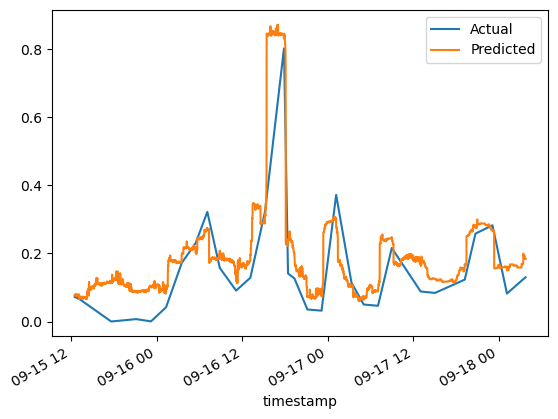

In [107]:
val_results_xgb.plot()

In [108]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
print("Validation RMSE:", rmse_val)

Validation RMSE: 0.08895905992748489


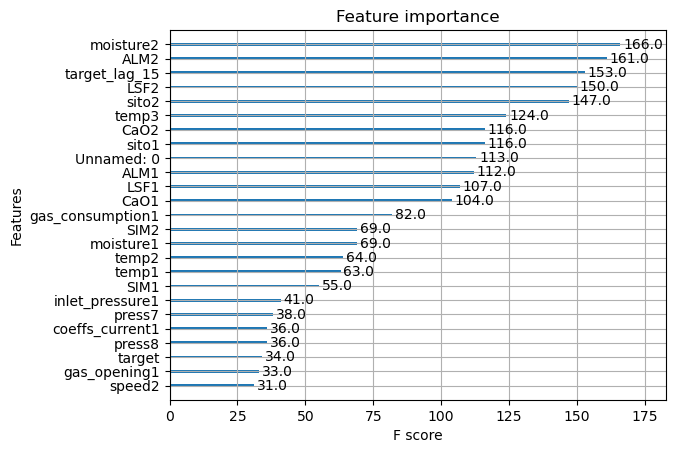

In [109]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances = model_xgb.feature_importances_

# Создание DataFrame для удобства
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plot_importance(model_xgb, max_num_features=25, importance_type='weight')
plt.show()

### LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13437
[LightGBM] [Info] Number of data points in the train set: 13382, number of used features: 63
[LightGBM] [Info] Start training from score 0.181734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

<Axes: xlabel='timestamp'>

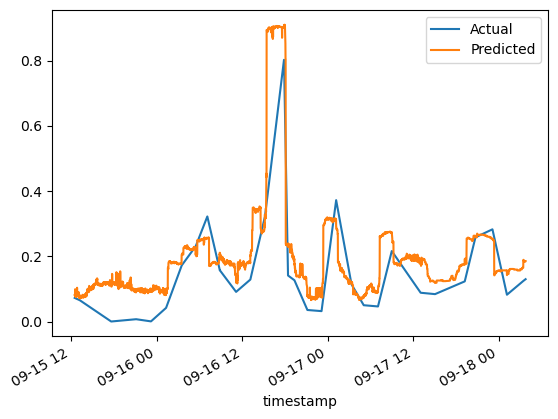

In [110]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Очистка названий признаков от специальных символов для X_train и X_val
import re
X_train.columns = [re.sub(r'\W+', '_', col) for col in X_train.columns]
X_val.columns = [re.sub(r'\W+', '_', col) for col in X_val.columns]

# Инициализация и обучение модели LGBMRegressor
model = LGBMRegressor(objective='regression', learning_rate=0.1, max_depth=5, num_leaves=31, n_estimators=100)
model.fit(X_train, y_train)

# Прогнозирование на валидационном наборе
y_pred_val_lgbm = model.predict(X_val)

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_lgbm))
print("Validation RMSE:", rmse_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results_lgbm = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val_lgbm
})

# Отображение первых нескольких строк
val_results_lgbm.plot()

In [111]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Вычисление RMSE для предсказаний
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_lgbm))
print("Validation RMSE:", rmse_val)

Validation RMSE: 0.09831622440415508


Линейная регрессия показала себя лучше всего. Дальше будем использовать ее.

## 2 Прогноз на 15 минут в перед

In [112]:
import pandas as pd 

df_data = pd.read_csv('data_lec.csv',  parse_dates=['timestamp'])
df_target = pd.read_csv('target_lec.csv',  parse_dates=['timestamp'])

In [113]:
# Приведение данных к временной шкале с фиксированным шагом
# Устанавливаем индекс для временных меток
df_data.set_index('timestamp', inplace=True)
df_target.set_index('timestamp', inplace=True)

# Интерполяция target на частоту data (1 минута)
df_target_interpolated = df_target.resample('1T').interpolate(method='linear')

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\2389438463.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_target_interpolated = df_target.resample('1T').interpolate(method='linear')


In [114]:
start_date = df_target_interpolated.index.min()
end_date = df_target_interpolated.index.max()

# Выделим нужный участок из df_data
df_data_selected = df_data.loc[start_date:end_date]

# Объединим df_data_selected с df_target_interpolated, добавив target в отдельную колонку
df_combined = df_data_selected.join(df_target_interpolated, rsuffix='_target')

In [115]:
df_combined['target_15min_future'] = df_combined['target_target'].shift(-15)
df_combined = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)
df_combined = df_combined.fillna(method='bfill').dropna()

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\2331083403.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_combined = df_combined.fillna(method='bfill').dropna()


In [116]:
# Вычисляем длины каждого набора
total_length = len(df_combined)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.9)

# Разделение данных
train_data = df_combined.iloc[:train_end]
val_data = df_combined.iloc[train_end:val_end]
test_data = df_combined.iloc[val_end:]

# Проверим размеры каждого набора для подтверждения
train_data_size = len(train_data)
val_data_size = len(val_data)
test_data_size = len(test_data)

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Подготовка признаков и целевой переменной
X_train = train_data.drop(columns=['target_15min_future'])
y_train = train_data['target_15min_future']

X_val =  val_data.drop(columns=['target_15min_future'])
y_val = val_data["target_15min_future"]

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на тренировочном наборе
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

rmse_train

0.011864494231221745

In [118]:
# Прогнозирование на валидационном наборе
y_pred_val = model.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

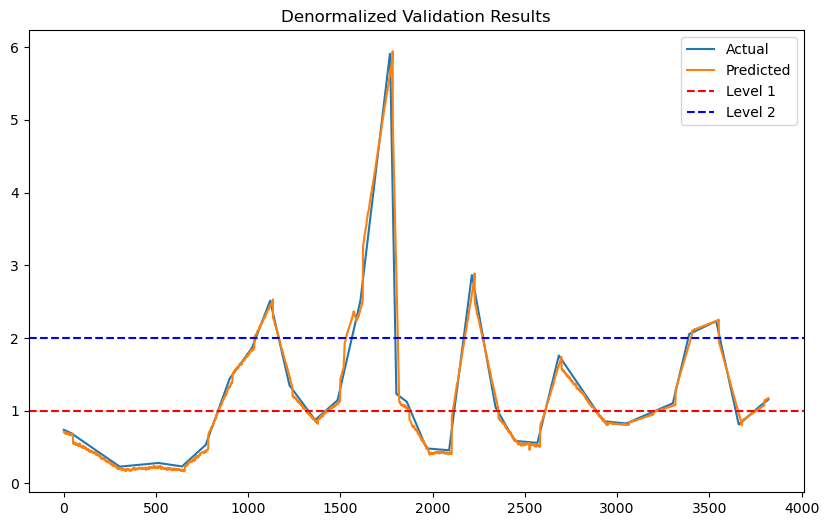

In [119]:
import matplotlib.pyplot as plt

# Денормализация 'Actual'
actual_denormalized = scaler.inverse_transform(val_data)[:, val_data.columns.get_loc('target_15min_future')]

# Денормализация 'Predicted'
predicted_denormalized = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_val), X_val.shape[1])), y_pred_val.reshape(-1, 1)])
)[:, -1]

# Создание DataFrame
val_results_denormalized = pd.DataFrame({
    'Actual': actual_denormalized,
    'Predicted': predicted_denormalized
})


# Построение графика
ax = val_results_denormalized.plot(figsize=(10, 6), title="Denormalized Validation Results")

# Добавление линий на уровне 1 и 2
ax.axhline(y=1, color='red', linestyle='--', label='Level 1')
ax.axhline(y=2, color='blue', linestyle='--', label='Level 2')

# Настройка легенды и отображение графика
ax.legend()
plt.show()

По графику видно что модель предсказывает достаточно хорошо

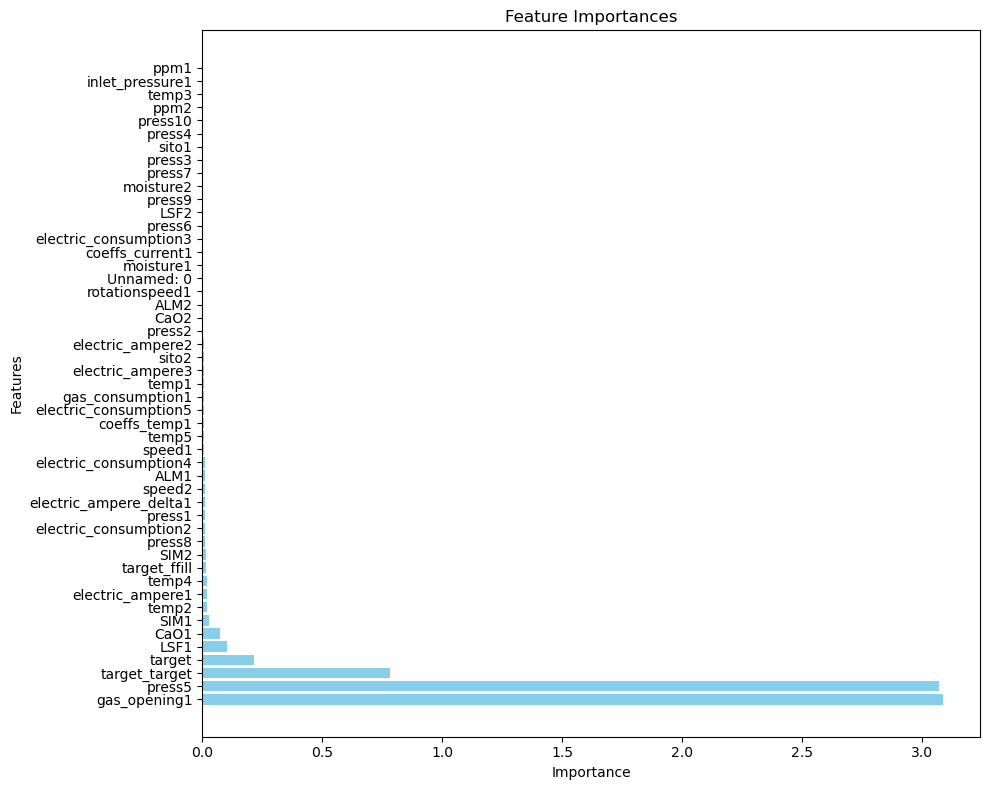

In [120]:
# Получение коэффициентов признаков
coefficients = model.coef_

# Создание DataFrame для визуализации
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)  # Абсолютное значение коэффициентов
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

# Построение графика важности признаков
# Построение горизонтального графика важности признаков
plt.figure(figsize=(10, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()  # Подгонка размеров графика
plt.show()

Все бы хорошо! Но значения target_target мы можем ресемплить когда получили фактические значения из лаборатории. По этому хорошим решением будет замена этой колонки на наш вертуальный датчик sensor значения которого мы можем получать в моменте.

In [121]:
# Для X_val заменим значения target_target на предсказания нашей первой модели.
common_index = X_val.index.intersection(sensor_val.index)

# Обновление значений только для общих индексов
X_val.loc[common_index, 'target_target'] = sensor_val.loc[common_index]

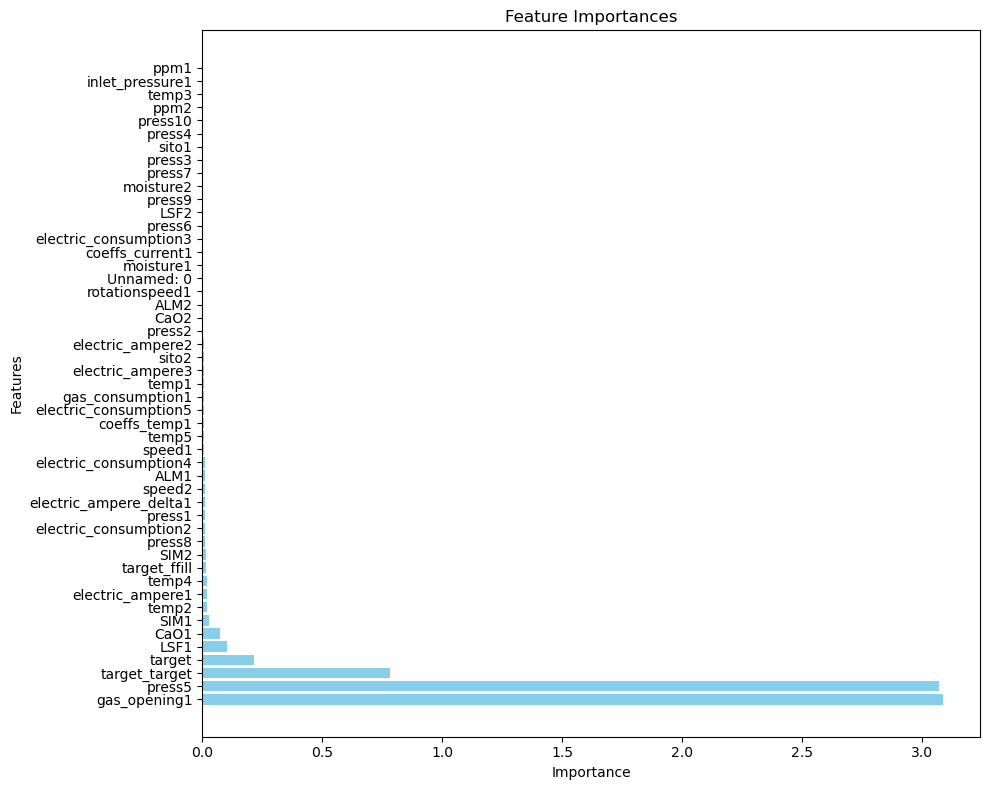

In [122]:
# Прогнозирование на валидационном наборе
y_pred_val = model.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

# Получение коэффициентов признаков
coefficients = model.coef_

# Создание DataFrame для визуализации
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)  # Абсолютное значение коэффициентов
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

# Построение графика важности признаков
# Построение горизонтального графика важности признаков
plt.figure(figsize=(10, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()  # Подгонка размеров графика
plt.show()

Как видно из графика нас могут интересовать переменные press5 и gas_opening1

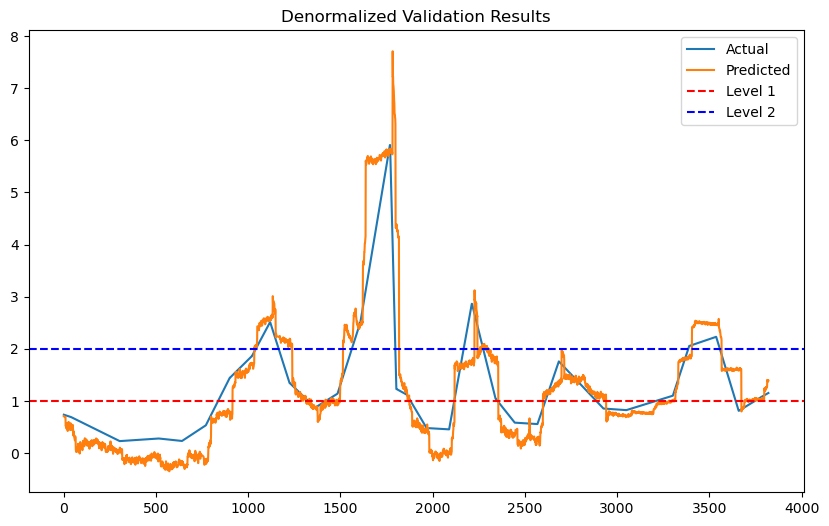

In [124]:
# Денормализация 'Actual'
actual_denormalized = scaler.inverse_transform(val_data)[:, val_data.columns.get_loc('target_15min_future')]

# Денормализация 'Predicted'
predicted_denormalized = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_pred_val), X_val.shape[1])), y_pred_val.reshape(-1, 1)])
)[:, -1]

# Создание DataFrame
val_results_denormalized = pd.DataFrame({
    'Actual': actual_denormalized,
    'Predicted': predicted_denormalized
})


# Построение графика
ax = val_results_denormalized.plot(figsize=(10, 6), title="Denormalized Validation Results")

# Добавление линий на уровне 1 и 2
ax.axhline(y=1, color='red', linestyle='--', label='Level 1')
ax.axhline(y=2, color='blue', linestyle='--', label='Level 2')

# Настройка легенды и отображение графика
ax.legend()
plt.show()

# 3 Построить модель, которая может определить значение таргета в случае изменения показателя gas_consumption1 на шаг 150 (текущее значение + 150) в последующие 15 минут.

In [127]:
import pandas as pd 

df_data = pd.read_csv('data_lec.csv',  parse_dates=['timestamp'])
df_target = pd.read_csv('target_lec.csv',  parse_dates=['timestamp'])

# Приведение данных к временной шкале с фиксированным шагом
# Устанавливаем индекс для временных меток
df_data.set_index('timestamp', inplace=True)
df_target.set_index('timestamp', inplace=True)

# Интерполяция target на частоту data (1 минута)
df_target_interpolated = df_target.resample('1T').interpolate(method='linear')

start_date = df_target_interpolated.index.min()
end_date = df_target_interpolated.index.max()

# Выделим нужный участок из df_data
df_data_selected = df_data.loc[start_date:end_date]

# Объединим df_data_selected с df_target_interpolated, добавив target в отдельную колонку
df_combined = df_data_selected.join(df_target_interpolated, rsuffix='_target')

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\2374762836.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_target_interpolated = df_target.resample('1T').interpolate(method='linear')


In [136]:
data = df_combined[['target_target', 'gas_consumption1']]

data['target_15min_future'] = data['target_target'].shift(-15)
# Вычисление разницы между текущим и предыдущим значением
data['gas_change_flag'] = data['gas_consumption1'].diff().abs() >= 150

# Преобразование в числовой формат (1 для True, 0 для False)
data['gas_change_flag'] = data['gas_change_flag'].astype(int)

# Проверка результата
data = data.fillna(method='bfill').dropna()

# Вычисляем длины каждого набора
total_length = len(df_combined)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.9)

# Разделение данных
train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Подготовка признаков и целевой переменной
X_train = train_data.drop(columns=['target_15min_future'])
y_train = train_data['target_15min_future']

X_val =  val_data.drop(columns=['target_15min_future'])
y_val = val_data["target_15min_future"]

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на тренировочном наборе
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

rmse_train

C:\Users\minak\AppData\Local\Temp\ipykernel_50108\3756934987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target_15min_future'] = data['target_target'].shift(-15)
C:\Users\minak\AppData\Local\Temp\ipykernel_50108\3756934987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gas_change_flag'] = data['gas_consumption1'].diff().abs() >= 150
C:\Users\minak\AppData\Local\Temp\ipykernel_50108\3756934987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

0.14343820827430515

0.21144988295759415

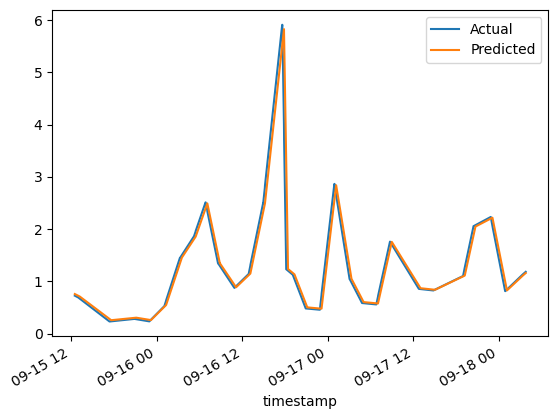

In [139]:
# Прогнозирование на валидационном наборе
y_pred_val = model.predict(X_val)

# Создание DataFrame с реальными и предсказанными значениями для удобного отображения
val_results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})

val_results.plot()

mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)

rmse_val

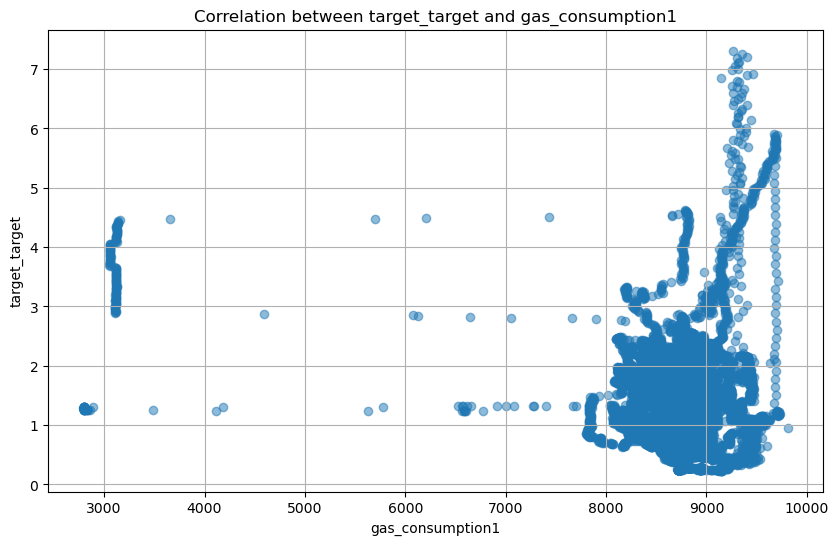

In [142]:
import matplotlib.pyplot as plt

# Построение графика корреляции между target_target и gas_consumption1
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['gas_consumption1'], df_combined['target_target'], alpha=0.5)
plt.title('Correlation between target_target and gas_consumption1')
plt.xlabel('gas_consumption1')
plt.ylabel('target_target')
plt.grid(True)
plt.show()

Интересно а почему мы взяли эту переменную а не gas_opening1 изменения которой кажется больше влияют на модель!?

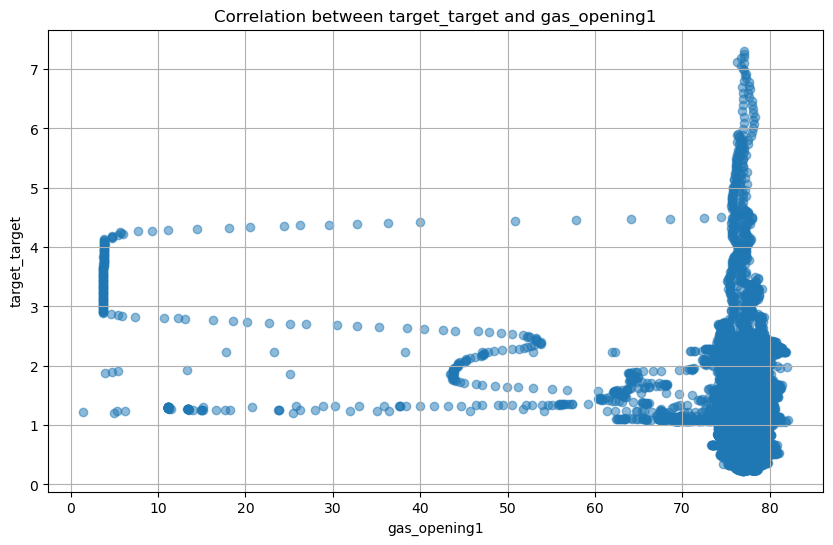

In [144]:
import matplotlib.pyplot as plt

# Построение графика корреляции между target_target и gas_consumption1
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['gas_opening1'], df_combined['target_target'], alpha=0.5)
plt.title('Correlation between target_target and gas_opening1')
plt.xlabel('gas_opening1')
plt.ylabel('target_target')
plt.grid(True)
plt.show()

На графике gas_opening1 кажется более устойчивые зависимости и можно построить более хорошую модель